In [1]:
%pylab inline
%matplotlib inline

import os
import sys
import numpy as np
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

Populating the interactive namespace from numpy and matplotlib


In [2]:
current_path = !pwd
parent_path = os.path.dirname(current_path[0])
if parent_path not in sys.path: sys.path.append(parent_path)
work_path = "/".join(parent_path.split('/')[:-1])
if work_path not in sys.path: sys.path.append(work_path)
santi_path = work_path+"/santi_iso_response"
santi_etc_path = os.path.join(santi_path, 'etc')
#if santi_path not in sys.path: sys.path.append(santi_path)
#if santi_etc_path not in sys.path: sys.path.append(santi_etc_path)

from santi_iso_response.models.cnn_sys_ident.data import Dataset, MonkeyDataset
from santi_iso_response.models.cnn_sys_ident.cnn import ConvNet
from santi_iso_response.iso_response.utils import load_model
import utils.model_handling as model_funcs
import utils.dataset_generation as iso_data
import utils.histogram_analysis as hist_funcs
import utils.plotting as pf

/gpfs01/bethge/home/dpaiton/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/gpfs01/bethge/home/dpaiton/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/gpfs01/bethge/home/dpaiton/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/gpfs01/bethge/home/dpaiton/.local/lib/python3

In [3]:
text_width = 416.83269 #pt = 14.65cm
fontsize = 12
dpi = 800
font_settings = {
        "text.usetex": True,
        "font.family": "serif",
        "axes.labelsize": fontsize,
        "axes.titlesize": fontsize,
        "figure.titlesize": fontsize,
        "font.size": fontsize,
        "legend.fontsize": fontsize,
        "xtick.labelsize": fontsize-2,
        "ytick.labelsize": fontsize-2,
}
mpl.rcParams.update(font_settings)
#os.environ["PATH"] += os.pathsep + '/gpfs01/bethge/home/dpaiton/bin/latex'
mpl.pyplot.rc('text', usetex=True)

color_vals = dict(zip(["blk", "lt_green", "md_green", "dk_green", "lt_blue", "md_blue", "dk_blue", "lt_red", "md_red", "dk_red"],
  ["#000000", "#A9DFBF", "#196F3D", "#27AE60", "#AED6F1", "#3498DB", "#21618C", "#F5B7B1", "#E74C3C", "#943126"]))

### Load Model

In [4]:
model = load_model()

W0207 17:10:26.936559 140030597949248 deprecation_wrapper.py:119] From /gpfs01/bethge/home/dpaiton/Work/santi_iso_response/models/cnn_sys_ident/base.py:38: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0207 17:10:26.960343 140030597949248 deprecation_wrapper.py:119] From /gpfs01/bethge/home/dpaiton/Work/santi_iso_response/models/cnn_sys_ident/utils.py:25: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0207 17:10:26.991657 140030597949248 deprecation_wrapper.py:119] From /gpfs01/bethge/home/dpaiton/Work/santi_iso_response/models/cnn_sys_ident/utils.py:35: The name tf.add_to_collection is deprecated. Please use tf.compat.v1.add_to_collection instead.

W0207 17:10:27.336017 140030597949248 deprecation_wrapper.py:119] From /gpfs01/bethge/home/dpaiton/Work/santi_iso_response/models/cnn_sys_ident/cnn.py:74: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0207 17:10:27.

Get a few images from a training set:

In [5]:
images,_,_ = model.data.train()

Get the activations for the first 10 images for all 166 neurons

In [6]:
activations = model_funcs.get_activations(model, images[:10])
print(activations.shape)

(10, 166)


Get the activations for only one cell (eg. cell 26) for the first 10 images

In [7]:
activations = model_funcs.get_activations_cell(model, images[:10], 26)
print(activations.shape)

(10,)


### Load MEIs

In [8]:
with open(os.path.join(santi_etc_path, 'meis.pkl'), 'rb') as g:
    meis = pickle.load(g)

In [9]:
images, activations, performance = meis['images'], meis['activations'], meis['performance']

#### visualize meis

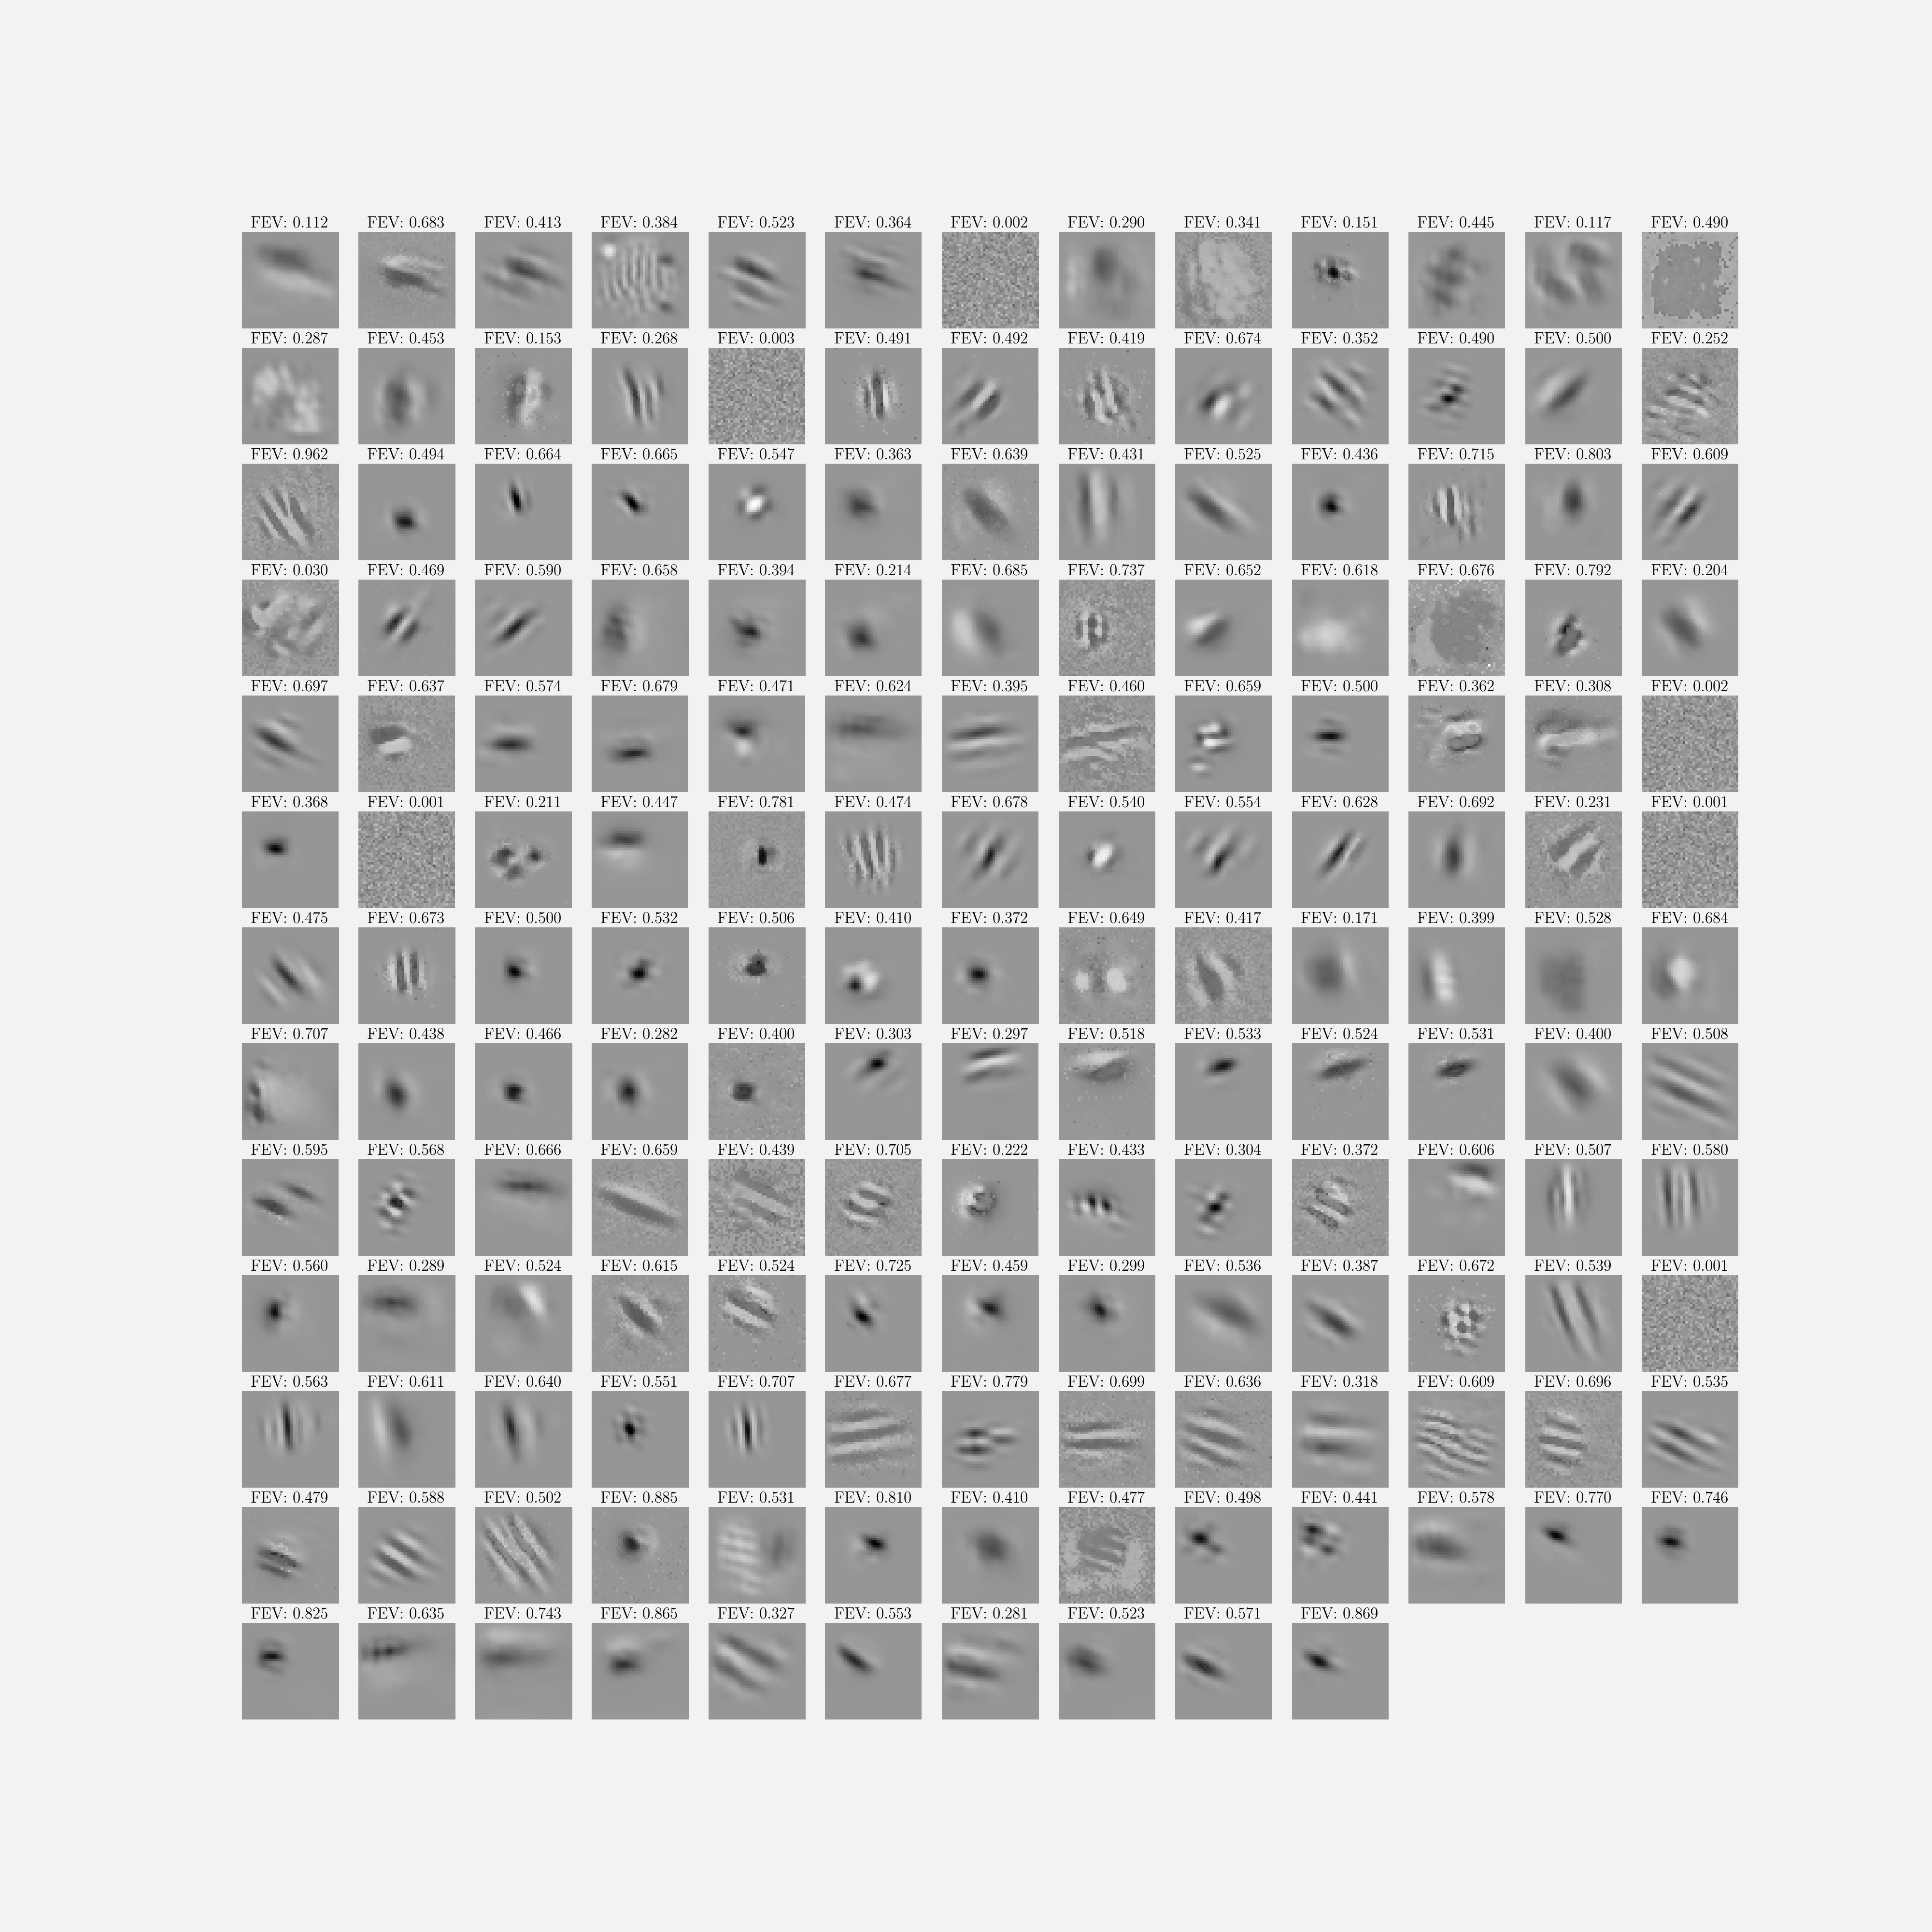

In [10]:
num_neurons = len(images)
fig, axes = plt.subplots(13,13, figsize=(20,20))
vmin = -3
vmax = 3

for ind, ax in enumerate(axes.flatten()):
    if ind < num_neurons:
        ax.imshow(images[ind], cmap=mpl.cm.Greys_r, vmin=vmin, vmax=vmax)
        ax.set_title('FEV: {:.3f}'.format(performance[ind])) # set as title the fraction of explainable variance explained
    ax.axis('off')
    

Get the activations from the MEI of neuron 43

In [11]:
model_funcs.get_activations_cell(model, meis['images'][43][np.newaxis,:,:], 43)

array([3.359448], dtype=float32)

In [12]:
meis['activations'][43]

3.359448

In [13]:
meis['performance'][43] # explainable variance explained for neuron 43

0.394098

In [14]:
len(meis["images"])

166

### Iso-response analysis

In [15]:
cont_analysis = dict()

#cont_analysis["target_neuron_ids"] = get_rand_target_neuron_ids(3, len(meis["images"]))
cont_analysis["target_neuron_ids"] = [1, 32, 36] # supposed simple cells
cont_analysis["num_comparisons"] = 3
cont_analysis["min_angle"] = 5
cont_analysis["x_range"] = (-2.0, 2.0)
cont_analysis["y_range"] = (-2.0, 2.0)
cont_analysis["num_images"] = int(30**2)
cont_analysis["image_scale"] = 12
neuron_meis = [meis["images"][idx] for idx in range(len(meis["images"]))]

iso_vectors = iso_data.compute_rand_iso_vectors(
    [neuron_meis[idx] for idx in cont_analysis["target_neuron_ids"]],
    cont_analysis["num_comparisons"])
cont_analysis["rand_target_vectors"] = iso_vectors[0]
cont_analysis["rand_orth_vectors"] = iso_vectors[1]

iso_vectors = iso_data.compute_comp_iso_vectors(
    neuron_meis,
    cont_analysis["target_neuron_ids"],
    cont_analysis["min_angle"],
    cont_analysis["num_comparisons"])
cont_analysis["comparison_neuron_ids"] = iso_vectors[0]
cont_analysis["comparison_target_vectors"] = iso_vectors[1]
cont_analysis["comparison_vectors"] = iso_vectors[2]

cont_analysis["target_vectors"] = cont_analysis["comparison_target_vectors"]

cont_analysis["contour_dataset"], datapoints = iso_data.get_contour_dataset(cont_analysis["target_vectors"], cont_analysis["comparison_vectors"], cont_analysis["x_range"], cont_analysis["y_range"], cont_analysis["num_images"], cont_analysis["image_scale"])

cont_analysis["activations"] = model_funcs.get_normalized_activations(model, cont_analysis["target_neuron_ids"],  datapoints)

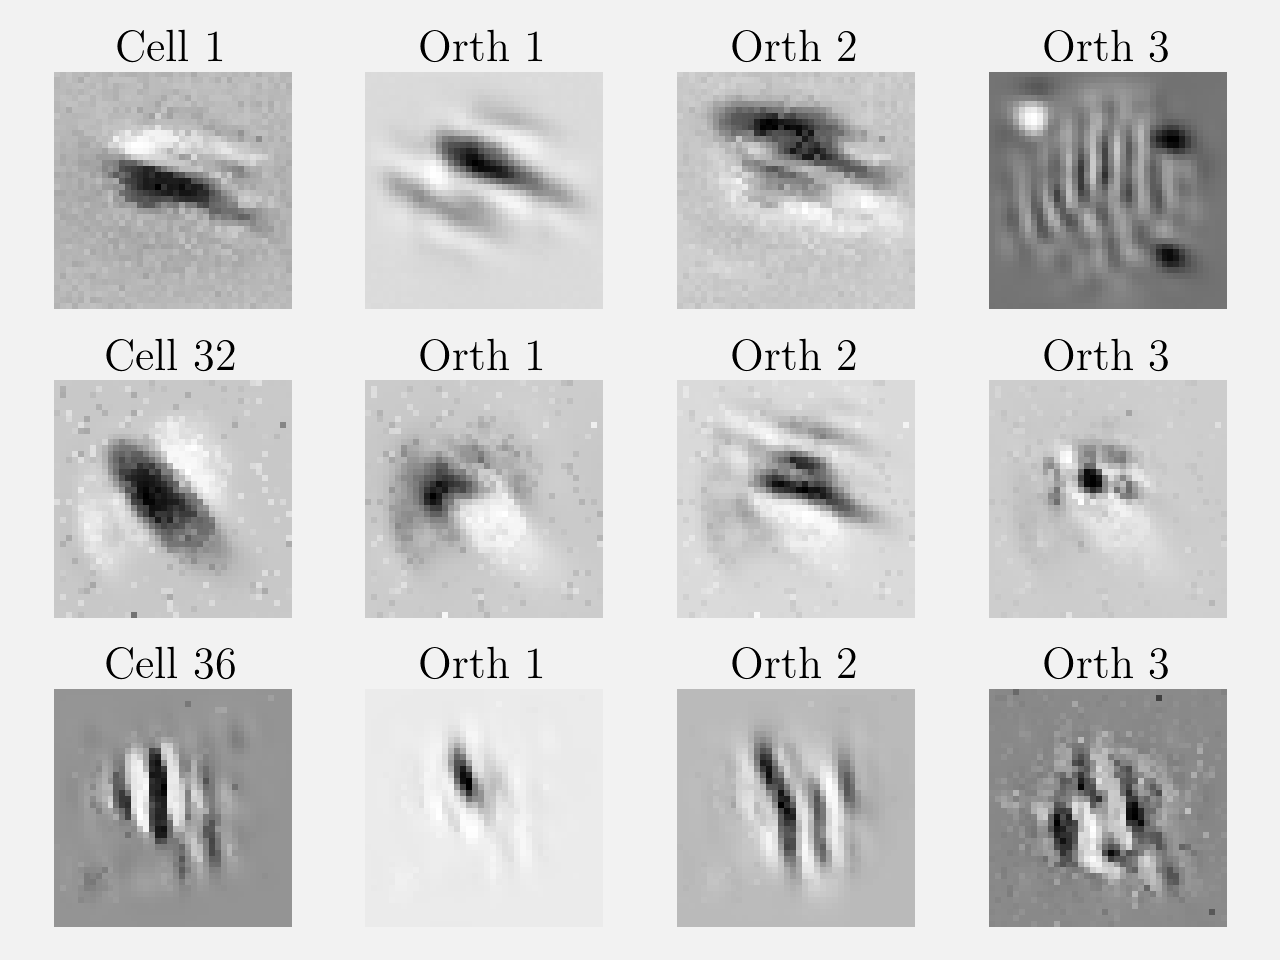

In [16]:
target0 = cont_analysis["target_vectors"][0].reshape((40,40))
target1 = cont_analysis["target_vectors"][1].reshape((40,40))
target2 = cont_analysis["target_vectors"][2].reshape((40,40))

comp00 = cont_analysis["comparison_vectors"][0][0].reshape((40,40))
comp01 = cont_analysis["comparison_vectors"][0][1].reshape((40,40))
comp02 = cont_analysis["comparison_vectors"][0][2].reshape((40,40))
orth00 = cont_analysis["contour_dataset"]["orth_vect"][0][0].reshape((40,40))
orth01 = cont_analysis["contour_dataset"]["orth_vect"][0][1].reshape((40,40))
orth02 = cont_analysis["contour_dataset"]["orth_vect"][0][2].reshape((40,40))

comp10 = cont_analysis["comparison_vectors"][1][0].reshape((40,40))
comp11 = cont_analysis["comparison_vectors"][1][1].reshape((40,40))
comp12 = cont_analysis["comparison_vectors"][1][2].reshape((40,40))
orth10 = cont_analysis["contour_dataset"]["orth_vect"][1][0].reshape((40,40))
orth11 = cont_analysis["contour_dataset"]["orth_vect"][1][1].reshape((40,40))
orth12 = cont_analysis["contour_dataset"]["orth_vect"][1][2].reshape((40,40))

comp20 = cont_analysis["comparison_vectors"][2][0].reshape((40,40))
comp21 = cont_analysis["comparison_vectors"][2][1].reshape((40,40))
comp22 = cont_analysis["comparison_vectors"][2][2].reshape((40,40))
orth20 = cont_analysis["contour_dataset"]["orth_vect"][2][0].reshape((40,40))
orth21 = cont_analysis["contour_dataset"]["orth_vect"][2][1].reshape((40,40))
orth22 = cont_analysis["contour_dataset"]["orth_vect"][2][2].reshape((40,40))

fig, axes = plt.subplots(3, 4)

ax = pf.clear_axis(axes[0, 0])
ax.imshow(target0, cmap=mpl.cm.Greys_r)
ax.set_title("Cell "+str(cont_analysis["target_neuron_ids"][0]), fontsize=16)
ax = pf.clear_axis(axes[1, 0])
ax.imshow(target1, cmap=mpl.cm.Greys_r)
ax.set_title("Cell "+str(cont_analysis["target_neuron_ids"][1]), fontsize=16)
ax = pf.clear_axis(axes[2, 0])
ax.imshow(target2, cmap=mpl.cm.Greys_r)
ax.set_title("Cell "+str(cont_analysis["target_neuron_ids"][2]), fontsize=16)

ax = pf.clear_axis(axes[0, 1])
ax.imshow(orth00, cmap=mpl.cm.Greys_r)
ax.set_title("Orth 1", fontsize=16)
ax = pf.clear_axis(axes[0, 2])
ax.imshow(orth01, cmap=mpl.cm.Greys_r)
ax.set_title("Orth 2", fontsize=16)
ax = pf.clear_axis(axes[0, 3])
ax.imshow(orth02, cmap=mpl.cm.Greys_r)
ax.set_title("Orth 3", fontsize=16)

ax = pf.clear_axis(axes[1, 1])
ax.imshow(orth10, cmap=mpl.cm.Greys_r)
ax.set_title("Orth 1", fontsize=16)
ax = pf.clear_axis(axes[1, 2])
ax.imshow(orth11, cmap=mpl.cm.Greys_r)
ax.set_title("Orth 2", fontsize=16)
ax = pf.clear_axis(axes[1, 3])
ax.imshow(orth12, cmap=mpl.cm.Greys_r)
ax.set_title("Orth 3", fontsize=16)

ax = pf.clear_axis(axes[2, 1])
ax.imshow(orth20, cmap=mpl.cm.Greys_r)
ax.set_title("Orth 1", fontsize=16)
ax = pf.clear_axis(axes[2, 2])
ax.imshow(orth21, cmap=mpl.cm.Greys_r)
ax.set_title("Orth 2", fontsize=16)
ax = pf.clear_axis(axes[2, 3])
ax.imshow(orth22, cmap=mpl.cm.Greys_r)
ax.set_title("Orth 3", fontsize=16)

fig.tight_layout(pad=1)
plt.show()

In [17]:
width_fraction = 1.0
show_contours = True
num_levels = 10
contour_fig, contour_handles = pf.plot_group_iso_contours(cont_analysis, num_levels, show_contours, text_width, width_fraction, dpi)

In [19]:
cont_analysis["target_neuron_ids"] = [1]

iso_vectors = iso_data.compute_comp_iso_vectors(
    neuron_meis,
    cont_analysis["target_neuron_ids"],
    cont_analysis["min_angle"],
    num_comparisons=2)
cont_analysis["comparison_neuron_ids"] = iso_vectors[0]
cont_analysis["target_vectors"] = iso_vectors[1]

extra_vect = meis["images"][18].reshape(meis["images"][18].size)
extra_vect = extra_vect / np.linalg.norm(extra_vect)
cont_analysis["comparison_vectors"] = [np.concatenate((iso_vector, extra_vect[None, ...]), axis=0)
    for iso_vector in iso_vectors[2]]

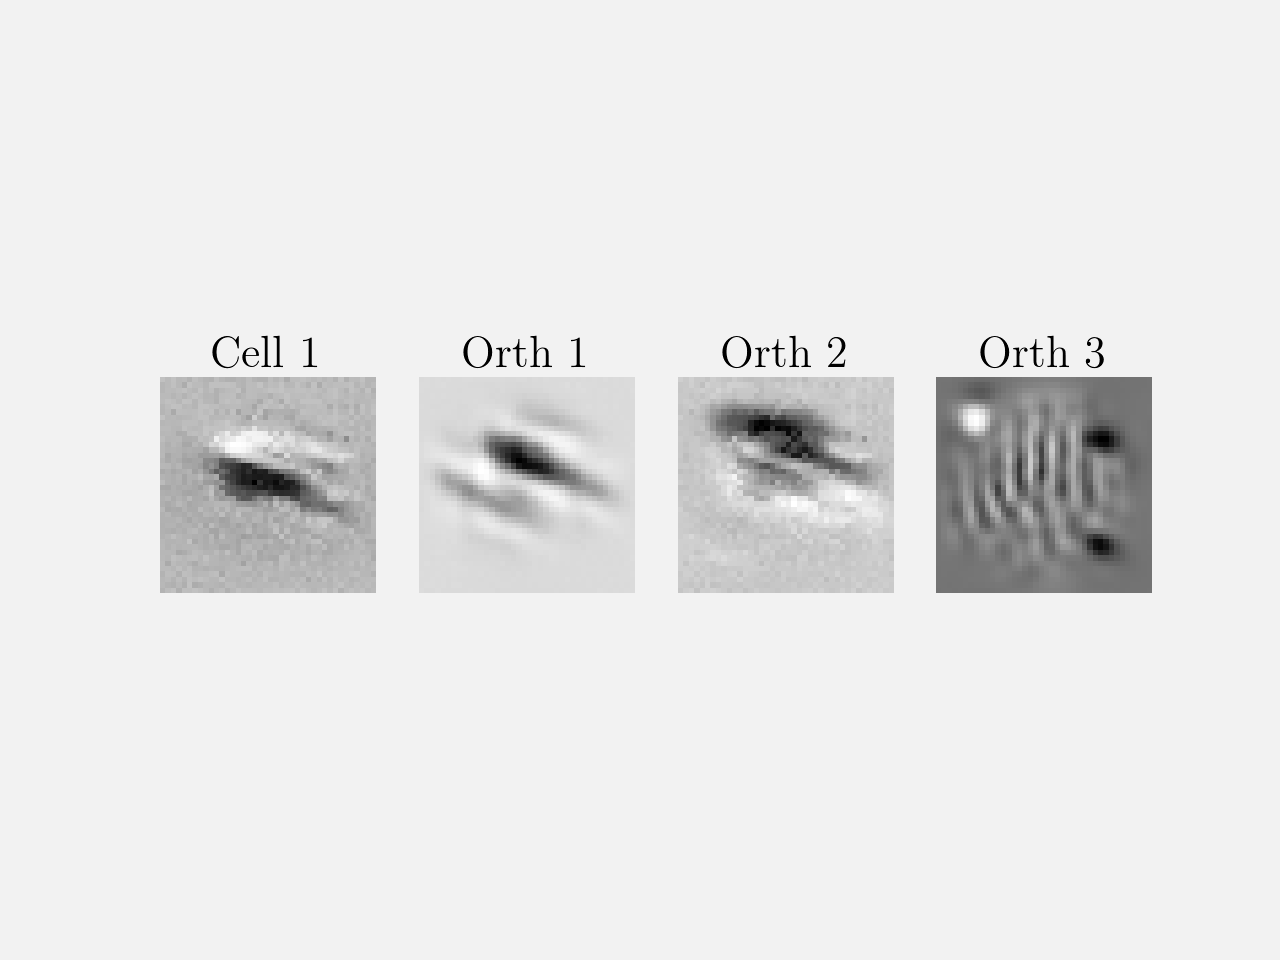

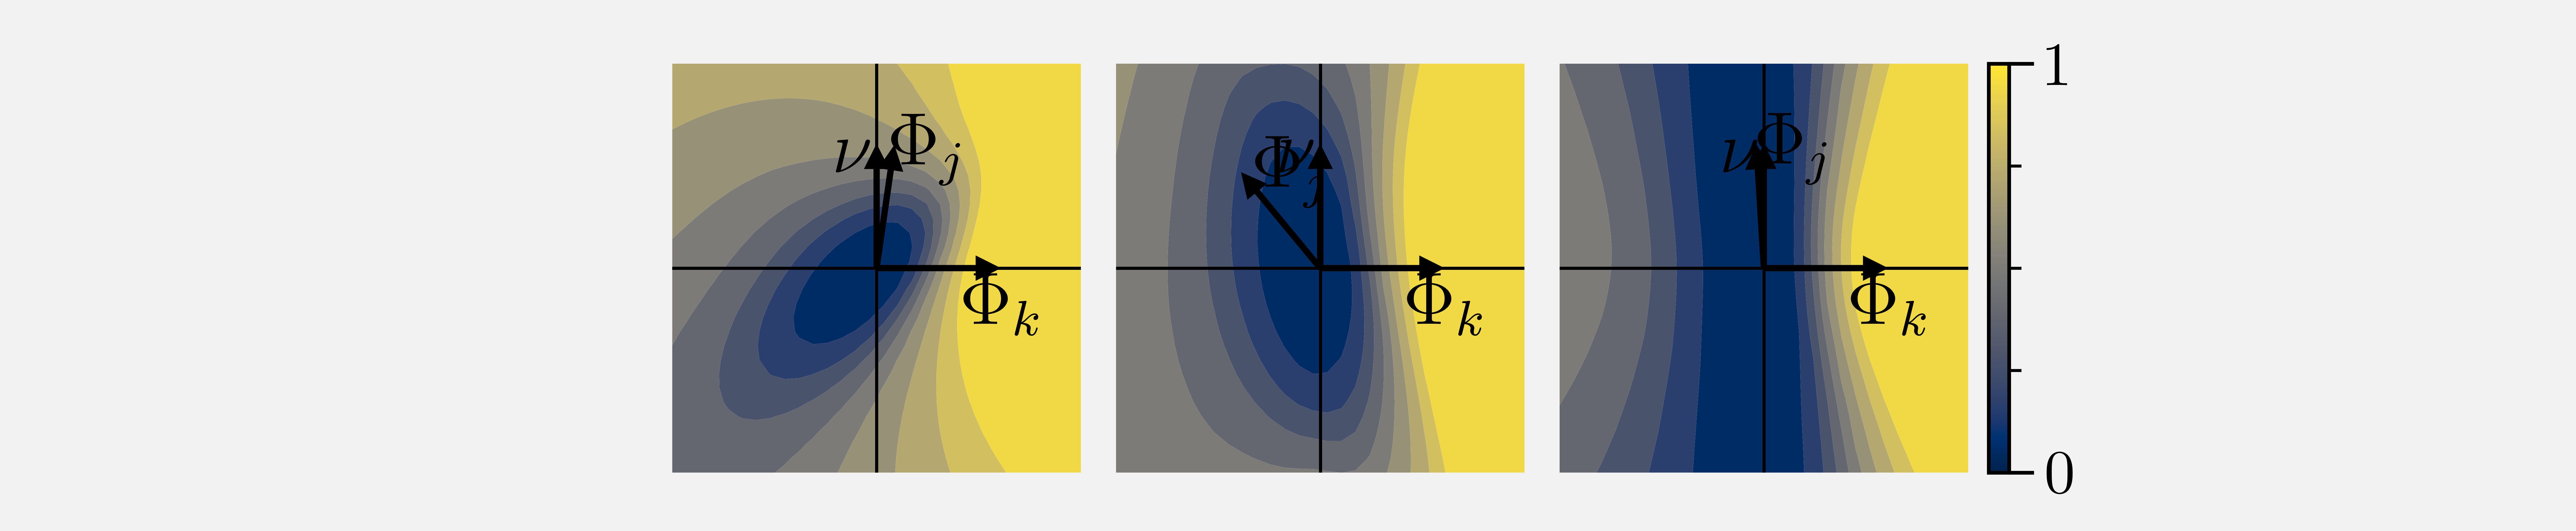

In [20]:
target = cont_analysis["target_vectors"][0].reshape((40,40))
comp1 = cont_analysis["comparison_vectors"][0][0].reshape((40,40))
comp2 = cont_analysis["comparison_vectors"][0][1].reshape((40,40))
comp3 = cont_analysis["comparison_vectors"][0][2].reshape((40,40))
orth1 = cont_analysis["contour_dataset"]["orth_vect"][0][0].reshape((40,40))
orth2 = cont_analysis["contour_dataset"]["orth_vect"][0][1].reshape((40,40))
orth3 = cont_analysis["contour_dataset"]["orth_vect"][0][2].reshape((40,40))
fig, axes = plt.subplots(1, 4)
axes[0] = pf.clear_axis(axes[0])
axes[0].imshow(target, cmap=mpl.cm.Greys_r)
axes[0].set_title("Cell "+str(cont_analysis["target_neuron_ids"][0]), fontsize=16)

#axes[1] = pf.clear_axis(axes[1])
#axes[1].imshow(comp1, cmap=mpl.cm.Greys_r)
#axes[1].set_title("Comp 1", fontsize=16)
#axes[2] = pf.clear_axis(axes[2])
#axes[2].imshow(comp2, cmap=mpl.cm.Greys_r)
#axes[2].set_title("Comp 2", fontsize=16)
#axes[3] = pf.clear_axis(axes[3])
#axes[3].imshow(comp3, cmap=mpl.cm.Greys_r)
#axes[3].set_title("Comp 3", fontsize=16)

axes[1] = pf.clear_axis(axes[1])
axes[1].imshow(orth1, cmap=mpl.cm.Greys_r)
axes[1].set_title("Orth 1", fontsize=16)
axes[2] = pf.clear_axis(axes[2])
axes[2].imshow(orth2, cmap=mpl.cm.Greys_r)
axes[2].set_title("Orth 2", fontsize=16)
axes[3] = pf.clear_axis(axes[3])
axes[3].imshow(orth3, cmap=mpl.cm.Greys_r)
axes[3].set_title("Orth 3", fontsize=16)

plt.show()

cont_analysis["contour_dataset"], datapoints = iso_data.get_contour_dataset(
    cont_analysis["target_vectors"],
    cont_analysis["comparison_vectors"],
    cont_analysis["x_range"],
    cont_analysis["y_range"],
    cont_analysis["num_images"],
    cont_analysis["image_scale"])
cont_analysis["activations"] = model_funcs.get_normalized_activations(
    model,
    cont_analysis["target_neuron_ids"],
    datapoints)
contour_fig, contour_handles = pf.plot_group_iso_contours(
    cont_analysis,
    num_levels,
    show_contours,
    text_width,
    width_fraction,
    dpi)

### Invariant MEIs

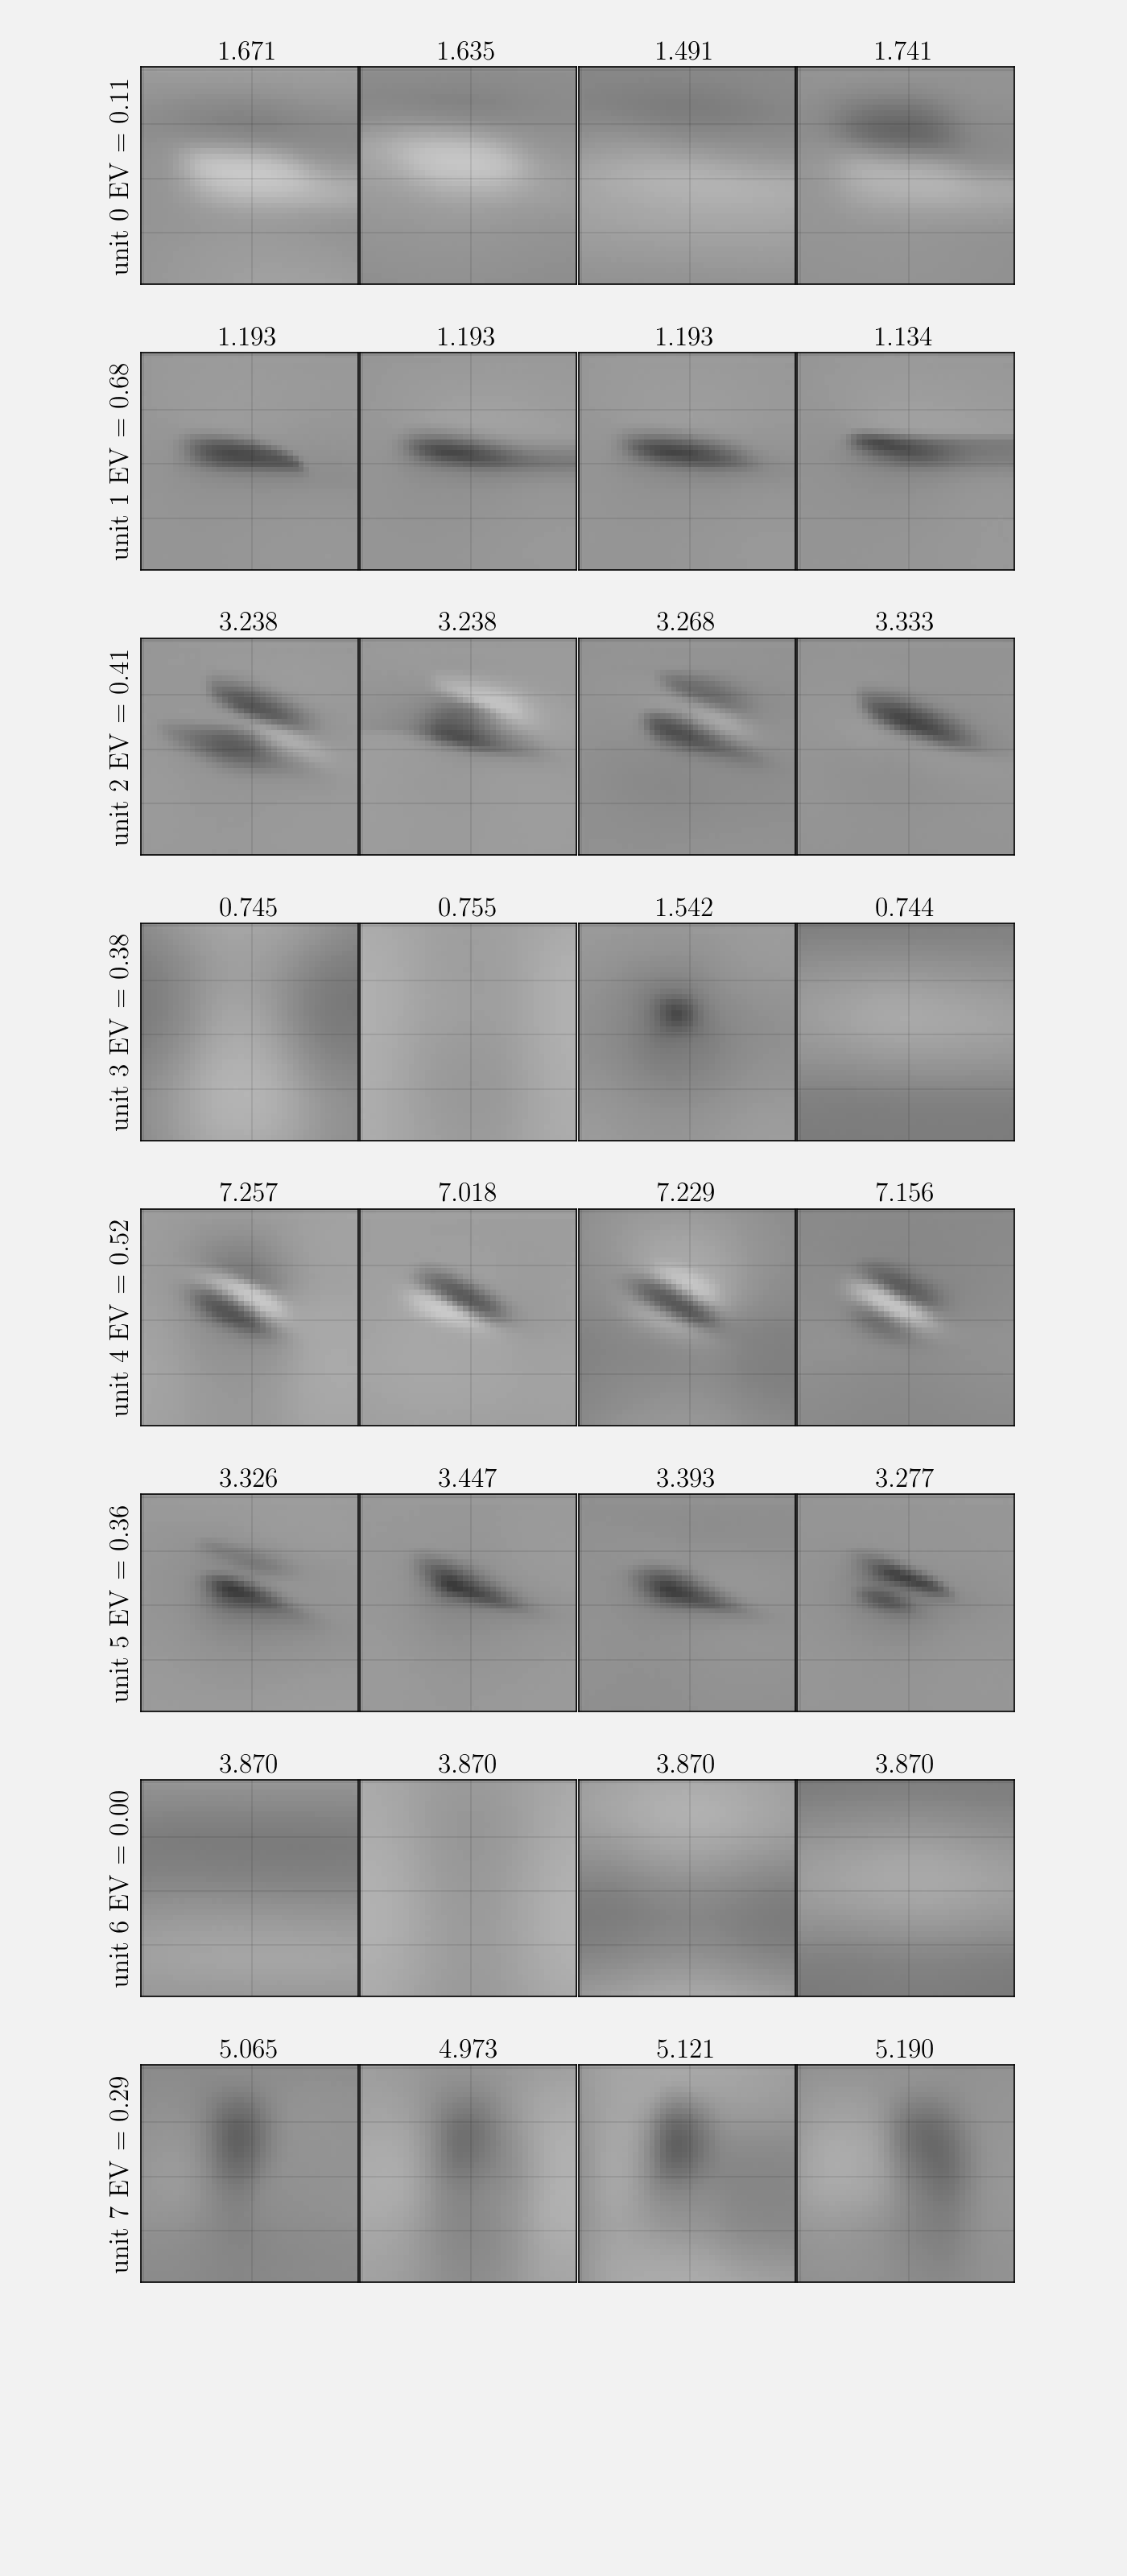

In [21]:
file_name = os.path.join(santi_etc_path, 'invariant_meis.pkl')
with open(file_name, 'rb') as h:
    invariant_meis = pickle.load(h)
images, activations, performances = invariant_meis['images'], invariant_meis['activations'], invariant_meis['performance']

num_units = 8 # Change to 166 for all of the neurons

fig = plt.figure(figsize = (7, num_units*2))
gs1 = gridspec.GridSpec(num_units, 4)
gs1.update(wspace=0.008, hspace=0.2, top = 0.978) # set the spacing between axes. 

for u in range(num_units * 4):
    ax = plt.subplot(gs1[u])
    imags = images[u//4]
    acts  = activations[u//4]
    perfs = performances[u//4]
    if u%4 ==0: ax.set_ylabel('unit %d EV = %.2f'%(u//4, perfs))
    ax.imshow(imags[u%4,:,:,0], vmax=3, vmin=-3, cmap=mpl.cm.Greys_r)
    ax.set_title('%.3f'%acts[u%4])
    ax.tick_params(axis= 'both', which='both', bottom=False, top=False, left = False, labelbottom=False, labelleft = False)

In [23]:
comp_vects = []
for invariant_mei_idx in range(images[4].shape[0]):
    invariant_mei = images[4][invariant_mei_idx,:,:,0]
    invariant_mei = invariant_mei.reshape([-1])
    invariant_mei = invariant_mei / np.linalg.norm(invariant_mei)
    comp_vects += [invariant_mei]
comp_mei = meis["images"][19]
comp_mei = comp_mei.reshape([-1])
comp_mei = comp_mei / np.linalg.norm(comp_mei)
comp_vects += [comp_mei]
comp_vects = np.stack(comp_vects, axis=0)

cont_analysis["target_neuron_ids"] = [4]
iso_vectors = iso_data.compute_comp_iso_vectors(
    neuron_meis,
    cont_analysis["target_neuron_ids"],
    cont_analysis["min_angle"],
    comp_vects.shape[0])

cont_analysis["comparison_neuron_ids"] = iso_vectors[0]
cont_analysis["target_vectors"] = iso_vectors[1]

cont_analysis["comparison_vectors"] = [np.stack(comp_vects, axis=0)
    for iso_vector in iso_vectors[2]]

cont_analysis["contour_dataset"], datapoints = iso_data.get_contour_dataset(
    cont_analysis["target_vectors"],
    cont_analysis["comparison_vectors"],
    cont_analysis["x_range"],
    cont_analysis["y_range"],
    cont_analysis["num_images"],
    cont_analysis["image_scale"])

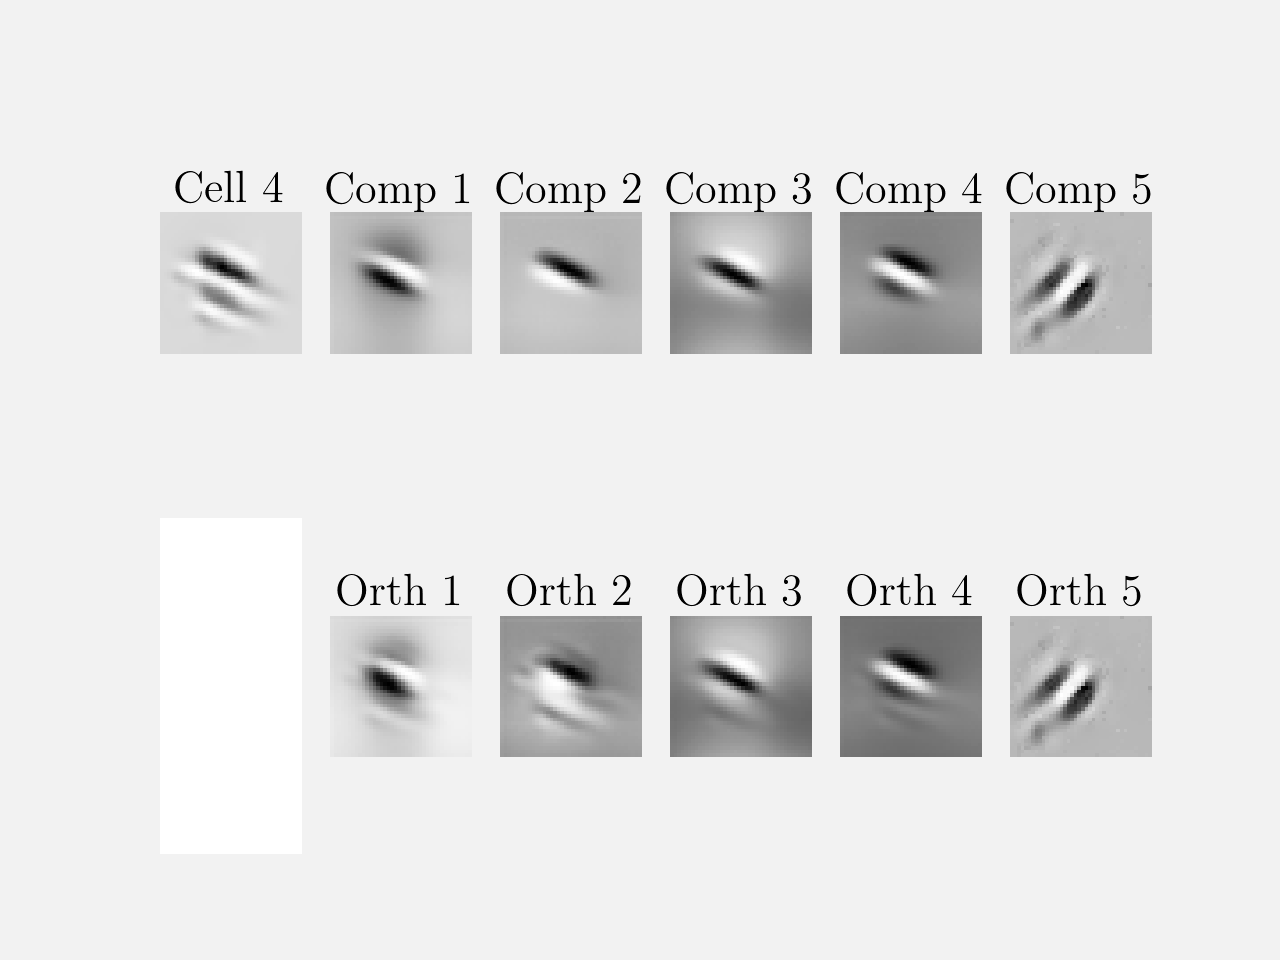

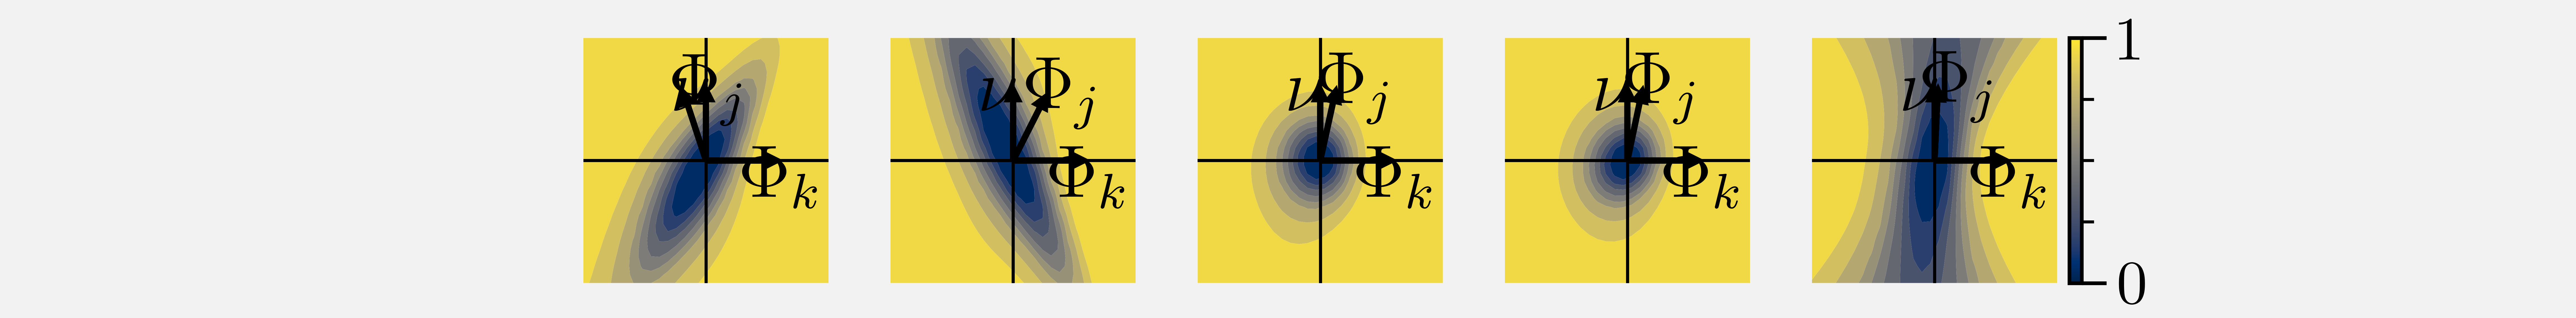

In [24]:
target = cont_analysis["target_vectors"][0].reshape((40,40))
comps = []
for target_idx in range(len(cont_analysis["target_neuron_ids"])):
    for plane_idx in range(cont_analysis["comparison_vectors"][target_idx].shape[0]):
        comps.append(cont_analysis["comparison_vectors"][target_idx][plane_idx, ...].reshape((40, 40)))

orths = []
for target_idx in range(len(cont_analysis["target_neuron_ids"])):
    for plane_idx in range(len(cont_analysis["contour_dataset"]["orth_vect"][target_idx])):
        orths.append(cont_analysis["contour_dataset"]["orth_vect"][target_idx][plane_idx].reshape((40, 40)))

fig, axes = plt.subplots(2, len(orths)+1)
ax = pf.clear_axis(axes[0, 0])
ax.imshow(target, cmap=mpl.cm.Greys_r)
ax.set_title("Cell "+str(cont_analysis["target_neuron_ids"][0]), fontsize=16)
ax = pf.clear_axis(axes[1, 0])

for comp_idx, comp in enumerate(comps):
  ax = pf.clear_axis(axes[0, comp_idx+1])
  ax.imshow(comp, cmap=mpl.cm.Greys_r)
  ax.set_title("Comp "+str(comp_idx+1), fontsize=16)

for orth_idx, orth in enumerate(orths):
  ax = pf.clear_axis(axes[1, orth_idx+1])
  ax.imshow(orth, cmap=mpl.cm.Greys_r)
  ax.set_title("Orth "+str(orth_idx+1), fontsize=16)

plt.show()

cont_analysis["activations"] = model_funcs.get_normalized_activations(
    model,
    cont_analysis["target_neuron_ids"],
    datapoints)
contour_fig, contour_handles = pf.plot_group_iso_contours(
    cont_analysis,
    num_levels,
    show_contours,
    text_width,
    width_fraction,
    dpi)

### Histograms

In [25]:
cont_analysis = dict()

cont_analysis["target_neuron_ids"] = [1, 32, 4]
cont_analysis["num_comparisons"] = 150
cont_analysis["min_angle"] = 5
cont_analysis["x_range"] = [-2.0, 2.0]
cont_analysis["y_range"] = [-2.0, 2.0]
cont_analysis["num_images"] = int(30**2)
cont_analysis["image_scale"] = 12
neuron_meis = [meis["images"][idx] for idx in range(len(meis["images"]))]

comp_iso_vectors = iso_data.compute_comp_iso_vectors(
    neuron_meis,
    cont_analysis["target_neuron_ids"],
    cont_analysis["min_angle"],
    cont_analysis["num_comparisons"])
cont_analysis["comparison_neuron_ids"] = comp_iso_vectors[0]
cont_analysis["comparison_target_vectors"] = comp_iso_vectors[1]
cont_analysis["comparison_vectors"] = comp_iso_vectors[2]

rand_iso_vectors = iso_data.compute_rand_iso_vectors(
    [neuron_meis[idx] for idx in cont_analysis["target_neuron_ids"]],
    cont_analysis["num_comparisons"])
cont_analysis["rand_target_vectors"] = rand_iso_vectors[0]
cont_analysis["rand_orth_vectors"] = rand_iso_vectors[1]

cont_analysis["comp_contour_dataset"], comp_datapoints = iso_data.get_contour_dataset(
    cont_analysis["comparison_target_vectors"],
    cont_analysis["comparison_vectors"],
    cont_analysis["x_range"],
    cont_analysis["y_range"],
    cont_analysis["num_images"],
    cont_analysis["image_scale"])

cont_analysis["rand_contour_dataset"], rand_datapoints = iso_data.get_contour_dataset(
    cont_analysis["rand_target_vectors"],
    cont_analysis["rand_orth_vectors"],
    cont_analysis["x_range"],
    cont_analysis["y_range"],
    cont_analysis["num_images"],
    cont_analysis["image_scale"])

In [26]:
cont_analysis["comp_activations"] = model_funcs.get_normalized_activations(
    model,
    cont_analysis["target_neuron_ids"],
    comp_datapoints)

cont_analysis["rand_activations"] = model_funcs.get_normalized_activations(
    model,
    cont_analysis["target_neuron_ids"],
    rand_datapoints)

In [27]:
target_act = 0.5 # target activity for computing response attenuation - between 0 and 1
num_bins = 50

# ((iso_comp_curvatures, iso_rand_curvatures), (attn_comp_curvatures, attn_rand_curvatures)) = curvatures
curvatures = hist_funcs.compute_curvature_fits(
    (cont_analysis["comp_activations"], cont_analysis["rand_activations"]),
    cont_analysis["comp_contour_dataset"],
    target_act)

# ((iso_comp_hist, iso_rand_hist), (attn_comp_hist, attn_rand_hist), (iso_bin_edges, attn_bin_edges)) = hists_and_bins
hists_and_bins = hist_funcs.compute_curvature_hists(curvatures, num_bins)

iso_title = "Iso-Response"
iso_hist_list = [[neuron_comp_hist for neuron_comp_hist in hists_and_bins[0][0]],
    [neuron_rand_hist for neuron_rand_hist in hists_and_bins[0][1]]]
plot_bin_lefts, plot_bin_rights = hists_and_bins[2][0][:-1], hists_and_bins[2][0][1:]
iso_plot_bin_centers = plot_bin_lefts + (plot_bin_rights - plot_bin_lefts)

attn_title = "Response Attenuation"
attn_hist_list = [[neuron_comp_hist for neuron_comp_hist in hists_and_bins[1][0]],
    [neuron_rand_hist for neuron_rand_hist in hists_and_bins[1][1]]]
plot_bin_lefts, plot_bin_rights = hists_and_bins[2][1][:-1], hists_and_bins[2][1][1:]
attn_plot_bin_centers = plot_bin_lefts + (plot_bin_rights - plot_bin_lefts)

label_list = [["Neuron "+str(neuron_id) for neuron_id in cont_analysis["target_neuron_ids"]]]*2
color_list = [
    [color_vals["lt_red"], color_vals["md_red"], color_vals["dk_red"]], # comparison colprs, one per neuron
    [color_vals["lt_blue"], color_vals["md_blue"], color_vals["dk_blue"]] # random colors, one per neuron
    ]
full_hist_list = [iso_hist_list, attn_hist_list]
full_label_list = [label_list,]*2
full_color_list = [color_list,]*2
full_bin_centers = [iso_plot_bin_centers, attn_plot_bin_centers]
full_title = [iso_title, attn_title]
full_xlabel = ["Curvature (Comparison)", "Curvature (Random)"]

curvature_fig = pf.plot_curvature_histograms(
    full_hist_list,
    full_label_list,
    full_color_list,
    full_bin_centers,
    full_title,
    full_xlabel,
    text_width=text_width,
    width_ratio=1.0,
    dpi=dpi)

In [28]:
cont_analysis = dict()

cont_analysis["target_neuron_ids"] = [1, 32, 4]
cont_analysis["num_comparisons"] = 150
cont_analysis["min_angle"] = 5
cont_analysis["x_range"] = [-2.0, 2.0]#[0.0, 1.0]
cont_analysis["y_range"] = [-2.0, 2.0]#[0.0, 1.0]
cont_analysis["num_images"] = int(30**2)
cont_analysis["image_scale"] = 12
neuron_meis = [meis["images"][idx] for idx in range(len(meis["images"]))]

iso_vectors = iso_data.compute_comp_iso_vectors(
    neuron_meis,
    cont_analysis["target_neuron_ids"],
    cont_analysis["min_angle"],
    cont_analysis["num_comparisons"])
cont_analysis["comparison_neuron_ids"] = iso_vectors[0]
cont_analysis["target_vectors"] = iso_vectors[1]
cont_analysis["comp_orth_vectors"] = iso_vectors[2]

rand_iso_vectors = iso_data.compute_rand_iso_vectors(
    [neuron_meis[idx] for idx in cont_analysis["target_neuron_ids"]],
    cont_analysis["num_comparisons"])
cont_analysis["rand_target_vectors"] = rand_iso_vectors[0]
cont_analysis["rand_orth_vectors"] = rand_iso_vectors[1]

# TODO: For each target neuron, sort stim images to find ones that have high inner product to the target. Then use those as comparison vectors.
stim_images = np.squeeze(model.data.train()[0])
num_stim = stim_images.shape[0]
image_indices = np.random.choice(range(num_stim), cont_analysis["num_comparisons"])
stim_images = stim_images[image_indices, ...].reshape([len(image_indices), stim_images[0, ...].size])
stim_images = stim_images / np.linalg.norm(stim_images, axis=1, keepdims=True)
cont_analysis["comparison_vectors"] = [stim_images]*3

cont_analysis["comp_contour_dataset"], comp_datapoints = iso_data.get_contour_dataset(
    cont_analysis["target_vectors"],
    cont_analysis["comparison_vectors"],
    cont_analysis["x_range"],
    cont_analysis["y_range"],
    cont_analysis["num_images"],
    cont_analysis["image_scale"])

cont_analysis["rand_contour_dataset"], rand_datapoints = iso_data.get_contour_dataset(
    cont_analysis["target_vectors"],
    cont_analysis["rand_orth_vectors"],
    cont_analysis["x_range"],
    cont_analysis["y_range"],
    cont_analysis["num_images"],
    cont_analysis["image_scale"])

In [29]:
cont_analysis["comp_activations"] = model_funcs.get_normalized_activations(
    model,
    cont_analysis["target_neuron_ids"],
    comp_datapoints)

cont_analysis["rand_activations"] = model_funcs.get_normalized_activations(
    model,
    cont_analysis["target_neuron_ids"],
    rand_datapoints)

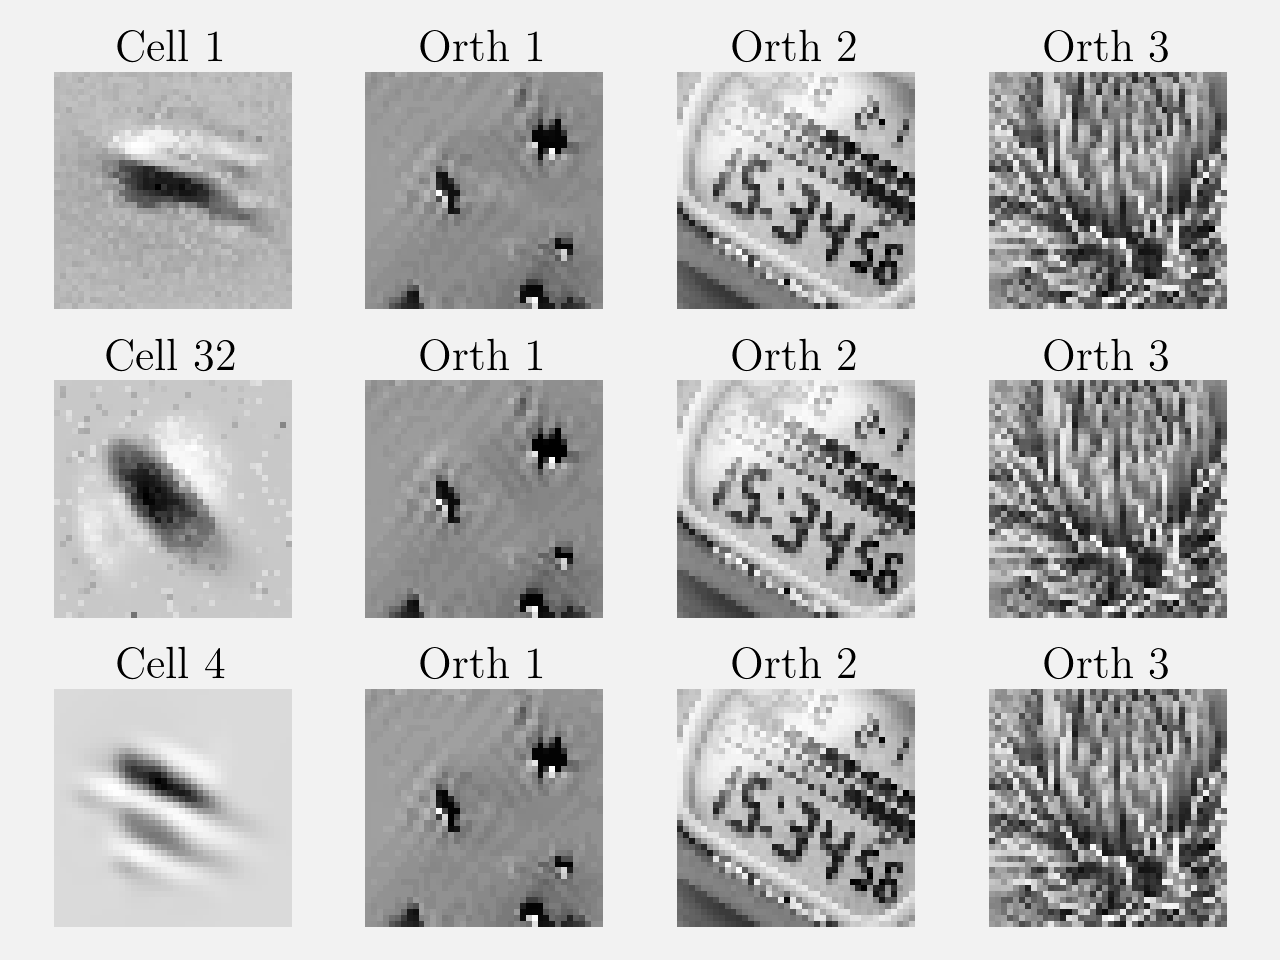

In [30]:
target0 = cont_analysis["target_vectors"][0].reshape((40,40))
target1 = cont_analysis["target_vectors"][1].reshape((40,40))
target2 = cont_analysis["target_vectors"][2].reshape((40,40))

comp00 = cont_analysis["comparison_vectors"][0][0].reshape((40,40))
comp01 = cont_analysis["comparison_vectors"][0][1].reshape((40,40))
comp02 = cont_analysis["comparison_vectors"][0][2].reshape((40,40))
orth00 = cont_analysis["comp_contour_dataset"]["orth_vect"][0][0].reshape((40,40))
orth01 = cont_analysis["comp_contour_dataset"]["orth_vect"][0][1].reshape((40,40))
orth02 = cont_analysis["comp_contour_dataset"]["orth_vect"][0][2].reshape((40,40))

comp10 = cont_analysis["comparison_vectors"][1][0].reshape((40,40))
comp11 = cont_analysis["comparison_vectors"][1][1].reshape((40,40))
comp12 = cont_analysis["comparison_vectors"][1][2].reshape((40,40))
orth10 = cont_analysis["comp_contour_dataset"]["orth_vect"][1][0].reshape((40,40))
orth11 = cont_analysis["comp_contour_dataset"]["orth_vect"][1][1].reshape((40,40))
orth12 = cont_analysis["comp_contour_dataset"]["orth_vect"][1][2].reshape((40,40))

comp20 = cont_analysis["comparison_vectors"][2][0].reshape((40,40))
comp21 = cont_analysis["comparison_vectors"][2][1].reshape((40,40))
comp22 = cont_analysis["comparison_vectors"][2][2].reshape((40,40))
orth20 = cont_analysis["comp_contour_dataset"]["orth_vect"][2][0].reshape((40,40))
orth21 = cont_analysis["comp_contour_dataset"]["orth_vect"][2][1].reshape((40,40))
orth22 = cont_analysis["comp_contour_dataset"]["orth_vect"][2][2].reshape((40,40))

fig, axes = plt.subplots(3, 4)

ax = pf.clear_axis(axes[0, 0])
ax.imshow(target0, cmap=mpl.cm.Greys_r)
ax.set_title("Cell "+str(cont_analysis["target_neuron_ids"][0]), fontsize=16)
ax = pf.clear_axis(axes[1, 0])
ax.imshow(target1, cmap=mpl.cm.Greys_r)
ax.set_title("Cell "+str(cont_analysis["target_neuron_ids"][1]), fontsize=16)
ax = pf.clear_axis(axes[2, 0])
ax.imshow(target2, cmap=mpl.cm.Greys_r)
ax.set_title("Cell "+str(cont_analysis["target_neuron_ids"][2]), fontsize=16)

ax = pf.clear_axis(axes[0, 1])
ax.imshow(orth00, cmap=mpl.cm.Greys_r)
ax.set_title("Orth 1", fontsize=16)
ax = pf.clear_axis(axes[0, 2])
ax.imshow(orth01, cmap=mpl.cm.Greys_r)
ax.set_title("Orth 2", fontsize=16)
ax = pf.clear_axis(axes[0, 3])
ax.imshow(orth02, cmap=mpl.cm.Greys_r)
ax.set_title("Orth 3", fontsize=16)

ax = pf.clear_axis(axes[1, 1])
ax.imshow(orth10, cmap=mpl.cm.Greys_r)
ax.set_title("Orth 1", fontsize=16)
ax = pf.clear_axis(axes[1, 2])
ax.imshow(orth11, cmap=mpl.cm.Greys_r)
ax.set_title("Orth 2", fontsize=16)
ax = pf.clear_axis(axes[1, 3])
ax.imshow(orth12, cmap=mpl.cm.Greys_r)
ax.set_title("Orth 3", fontsize=16)

ax = pf.clear_axis(axes[2, 1])
ax.imshow(orth20, cmap=mpl.cm.Greys_r)
ax.set_title("Orth 1", fontsize=16)
ax = pf.clear_axis(axes[2, 2])
ax.imshow(orth21, cmap=mpl.cm.Greys_r)
ax.set_title("Orth 2", fontsize=16)
ax = pf.clear_axis(axes[2, 3])
ax.imshow(orth22, cmap=mpl.cm.Greys_r)
ax.set_title("Orth 3", fontsize=16)

fig.tight_layout(pad=1)
plt.show()

In [31]:
cont_analysis["activations"] = cont_analysis["comp_activations"][:, :3]
cont_analysis["contour_dataset"] = cont_analysis["comp_contour_dataset"]
width_fraction = 1.0
show_contours = True
num_levels = 10
contour_fig, contour_handles = pf.plot_group_iso_contours(
    cont_analysis,
    num_levels,
    show_contours,
    text_width,
    width_fraction,
    dpi)

In [32]:
target_act = 0.75 # target activity for computing response attenuation - between 0 and 1
num_bins = 50

# ((iso_comp_curvatures, iso_rand_curvatures), (attn_comp_curvatures, attn_rand_curvatures)) = curvatures
curvatures = hist_funcs.compute_curvature_fits(
    (cont_analysis["comp_activations"],
    cont_analysis["rand_activations"]),
    cont_analysis["comp_contour_dataset"],
    target_act)

# ((iso_comp_hist, iso_rand_hist), (attn_comp_hist, attn_rand_hist), (iso_bin_edges, attn_bin_edges)) = hists_and_bins
hists_and_bins = hist_funcs.compute_curvature_hists(curvatures, num_bins)

iso_title = "Iso-Response"
iso_hist_list = [[neuron_comp_hist for neuron_comp_hist in hists_and_bins[0][0]],
    [neuron_rand_hist for neuron_rand_hist in hists_and_bins[0][1]]]
plot_bin_lefts, plot_bin_rights = hists_and_bins[2][0][:-1], hists_and_bins[2][0][1:]
iso_plot_bin_centers = plot_bin_lefts + (plot_bin_rights - plot_bin_lefts)

attn_title = "Response Attenuation"
attn_hist_list = [[neuron_comp_hist for neuron_comp_hist in hists_and_bins[1][0]],
    [neuron_rand_hist for neuron_rand_hist in hists_and_bins[1][1]]]
plot_bin_lefts, plot_bin_rights = hists_and_bins[2][1][:-1], hists_and_bins[2][1][1:]
attn_plot_bin_centers = plot_bin_lefts + (plot_bin_rights - plot_bin_lefts)

label_list = [["Neuron "+str(neuron_id) for neuron_id in cont_analysis["target_neuron_ids"]]]*2
color_list = [
    [color_vals["lt_red"], color_vals["md_red"], color_vals["dk_red"]], # comparison colprs, one per neuron
    [color_vals["lt_blue"], color_vals["md_blue"], color_vals["dk_blue"]] # random colors, one per neuron
    ]
full_hist_list = [iso_hist_list, attn_hist_list]
full_label_list = [label_list,]*2
full_color_list = [color_list,]*2
full_bin_centers = [iso_plot_bin_centers, attn_plot_bin_centers]
full_title = [iso_title, attn_title]
full_xlabel = ["Curvature (Comparison)", "Curvature (Random)"]

curvature_fig = pf.plot_curvature_histograms(
    full_hist_list,
    full_label_list,
    full_color_list,
    full_bin_centers,
    full_title,
    full_xlabel,
    text_width=text_width,
    width_ratio=1.0,
    dpi=dpi)